# Sparse Variational Dropout

<img src="https://ars-ashuha.github.io/images/ss_vd1.png", width=960>
<img src="https://ars-ashuha.github.io/images/ss_vd2.png", width=960>

# Install 

In [ ]:
!pip3 install http://download.pytorch.org/whl/cpu/torch-0.4.1-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [ ]:
# Logger
!pip install tabulate -q
from google.colab import files
src = list(files.upload().values())[0]
open('logger.py','wb').write(src)

In [1]:
from logger import Logger

/Users/ars/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Implementation

In [2]:
import math
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from logger import Logger
from torch.nn import Parameter
from torchvision import datasets, transforms

In [3]:
class LinearSVDO(nn.Module):
    def __init__(self, in_features, out_features, threshold, bias=True):
        super(LinearSVDO, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold

        self.W = Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(1, out_features))
        
        self.reset_parameters()

    def reset_parameters(self):
        self.bias.data.zero_()
        self.W.data.normal_(0, 0.02)
        self.log_sigma.data.fill_(-5)        
        
    def forward(self, x):
        self.log_alpha = self.log_sigma * 2.0 - torch.log(1e-16 + 2.0 * torch.abs(self.W))
        self.log_alpha = torch.clamp(self.log_alpha, -10, 10) 
        
        if self.training:
            lrt_mean =  F.linear(x, self.W) + self.bias
            lrt_std = torch.sqrt(F.linear(x * x, torch.exp(self.log_sigma * 2.0)) + 1e-8)
            eps = lrt_std.data.new(lrt_std.size()).normal_()
            return lrt_mean + lrt_std * eps
    
        return F.linear(x, self.W * (self.log_alpha < 3).float()) + self.bias
        
    def kl_reg(self):
        # Return KL here -- a scalar 
        k1, k2, k3 = torch.Tensor([0.63576]), torch.Tensor([1.8732]), torch.Tensor([1.48695])
        kl = k1 * torch.sigmoid(k2 + k3 * self.log_alpha) - 0.5 * torch.log1p(torch.exp(-self.log_alpha))
        a = - torch.sum(kl)
        return a

In [4]:
# Define a simple 2 layer Network
class Net(nn.Module):
    def __init__(self, threshold):
        super(Net, self).__init__()
        self.fc1 = LinearSVDO(28*28, 300, threshold)
        self.fc2 = LinearSVDO(300,  10, threshold)
        self.threshold = threshold

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [5]:
# Load a dataset
def get_mnist(batch_size):
    trsnform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [9]:
# Define New Loss Function -- SGVLB 
class SGVLB(nn.Module):
    def __init__(self, net, train_size):
        super(SGVLB, self).__init__()
        self.train_size = train_size
        self.net = net

    def forward(self, input, target, kl_weight=1.0):
        assert not target.requires_grad
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
        return F.cross_entropy(input, target) * self.train_size + kl_weight * kl

In [10]:
model = Net(threshold=3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,70,80], gamma=0.2)

fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
logger = Logger('sparse_vd', fmt=fmt)

train_loader, test_loader = get_mnist(batch_size=100)
sgvlb = SGVLB(model, len(train_loader.dataset))

In [11]:
kl_weight = 0.02
epochs = 100

for epoch in range(1, epochs + 1):
    scheduler.step()
    model.train()
    train_loss, train_acc = 0, 0 
    kl_weight = min(kl_weight+0.02, 1)
    logger.add_scalar(epoch, 'kl', kl_weight)
    logger.add_scalar(epoch, 'lr', scheduler.get_lr()[0])
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        
        output = model(data)
        pred = output.data.max(1)[1] 
        loss = sgvlb(output, target, kl_weight)
        loss.backward()
        optimizer.step()
        
        train_loss += loss 
        train_acc += np.sum(pred.numpy() == target.data.numpy())

    logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))
    logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)
    
    
    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.view(-1, 28*28)
        output = model(data)
        test_loss += float(sgvlb(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.numpy() == target.data.numpy())
        
    logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
    logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)
    
    for i, c in enumerate(model.children()):
        if hasattr(c, 'kl_reg'):
            logger.add_scalar(epoch, 'sp_%s' % i, (c.log_alpha.data.numpy() > model.threshold).mean())
            
    logger.iter_info()

  epoch    kl       lr    tr_los    tr_acc    te_loss    te_acc    sp_0    sp_1
-------  ----  -------  --------  --------  ---------  --------  ------  ------
      1  0.04  1.0e-03   4.1e+02      92.3    2.9e+02      96.2   0.001   0.000
      2  0.06  1.0e-03   2.8e+02      96.9    1.7e+02      97.5   0.018   0.000
      3  0.08  1.0e-03   1.4e+02      97.9    8.7e+01      97.9   0.074   0.000
      4  0.10  1.0e-03   5.6e+01      98.2    3.5e+01      98.1   0.131   0.000
      5  0.12  1.0e-03   7.1e+00      98.2   -2.5e+00      98.2   0.190   0.001
      6  0.14  1.0e-03  -3.1e+01      98.2   -3.4e+01      98.2   0.245   0.002
      7  0.16  1.0e-03  -5.9e+01      98.2   -5.8e+01      98.2   0.266   0.003
      8  0.18  1.0e-03  -9.1e+01      98.1   -9.5e+01      98.3   0.326   0.001
      9  0.20  1.0e-03  -1.2e+02      98.0   -1.2e+02      98.3   0.379   0.002
     10  0.22  1.0e-03  -1.5e+02      98.0   -1.5e+02      98.2   0.365   0.002
     11  0.24  1.0e-03  -1.8e+02      98

In [12]:
all_w, kep_w = 0, 0

for c in model.children():
    kep_w += (c.log_alpha.data.numpy() < model.threshold).sum()
    all_w += c.log_alpha.data.numpy().size

print('keept weight ratio =', all_w/kep_w)

keept weight ratio = 35.64267544515936


    # Good result should be like 
    #   epoch    kl       lr    tr_los    tr_acc    te_loss    te_acc    sp_0    sp_1
    #  -------  ----  -------  --------  --------  ---------  --------  ------  ------
    #      100     1  1.6e-06  -1.4e+03      98.0   -1.4e+03      98.3   0.969   0.760
    # keept weight ratio = 30.109973454683352

# Visualization

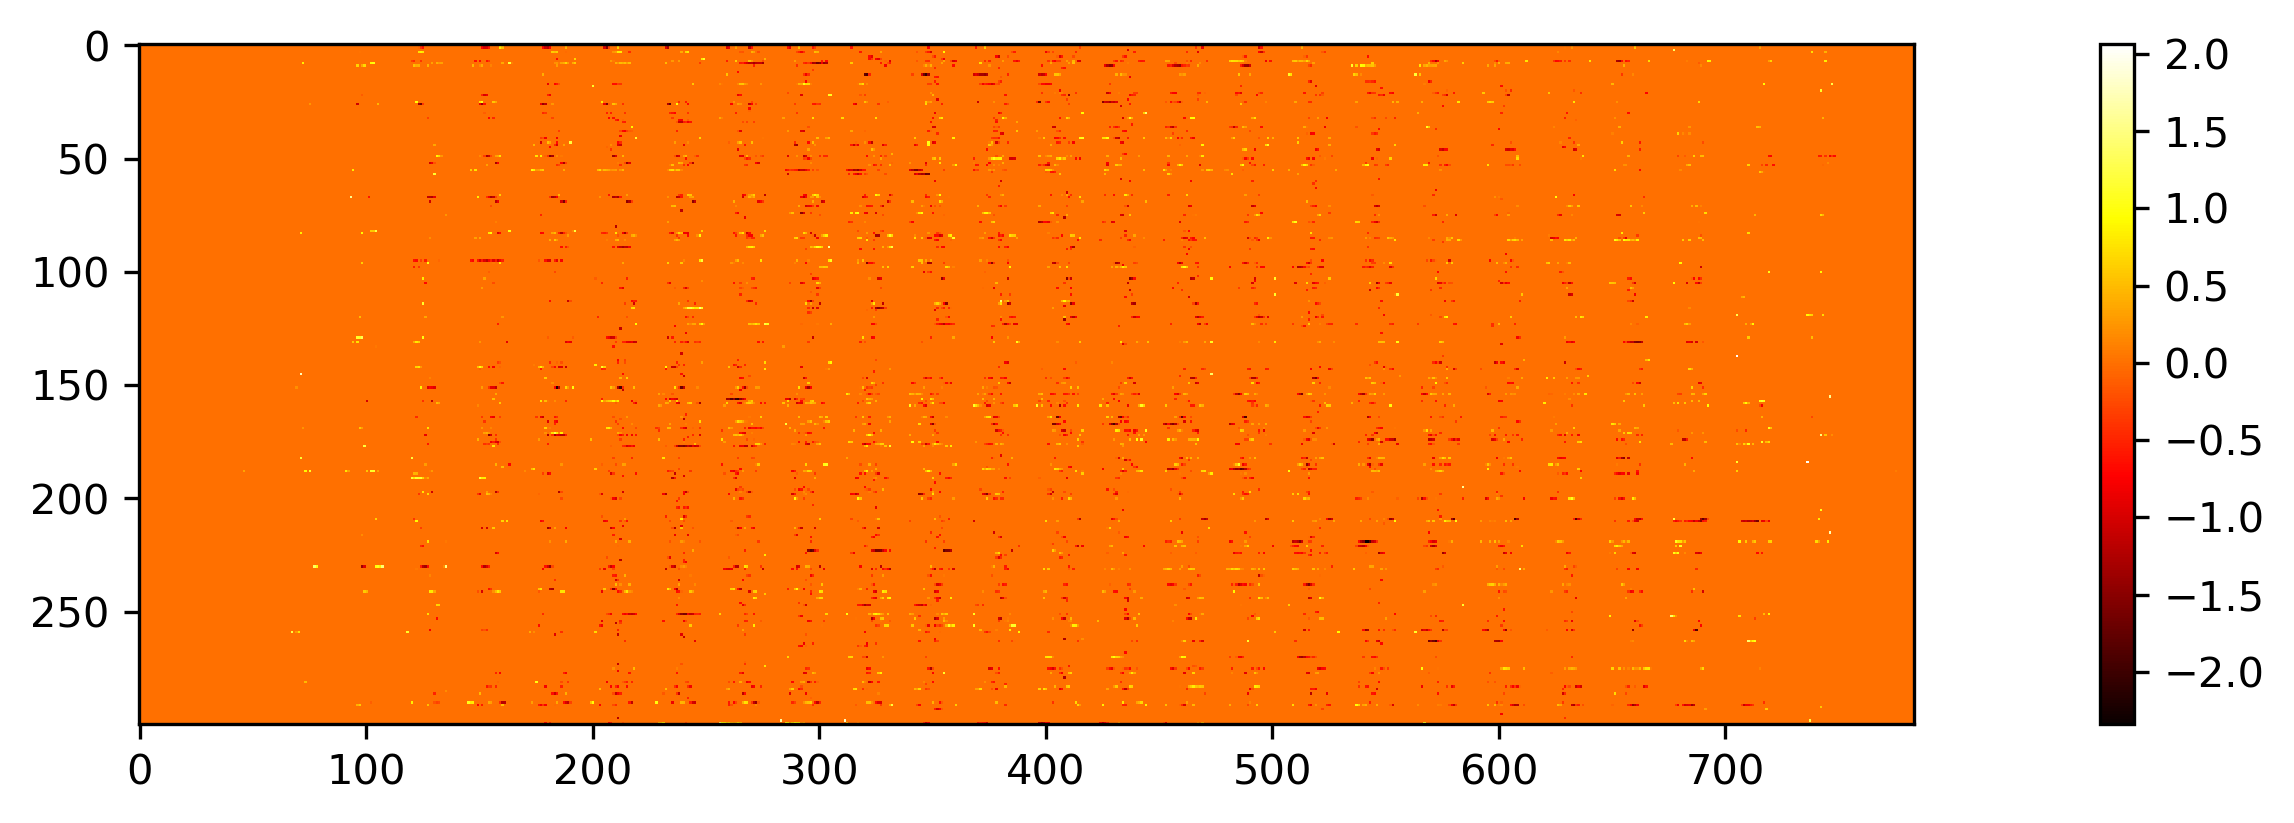

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 3
rcParams['figure.dpi'] = 300


log_alpha = (model.fc1.log_alpha.detach().numpy() < 3).astype(np.float)
W = model.fc1.W.detach().numpy()

plt.imshow(log_alpha * W, cmap='hot', interpolation=None)
plt.colorbar()

(-0.5, 279.5, 279.5, -0.5)

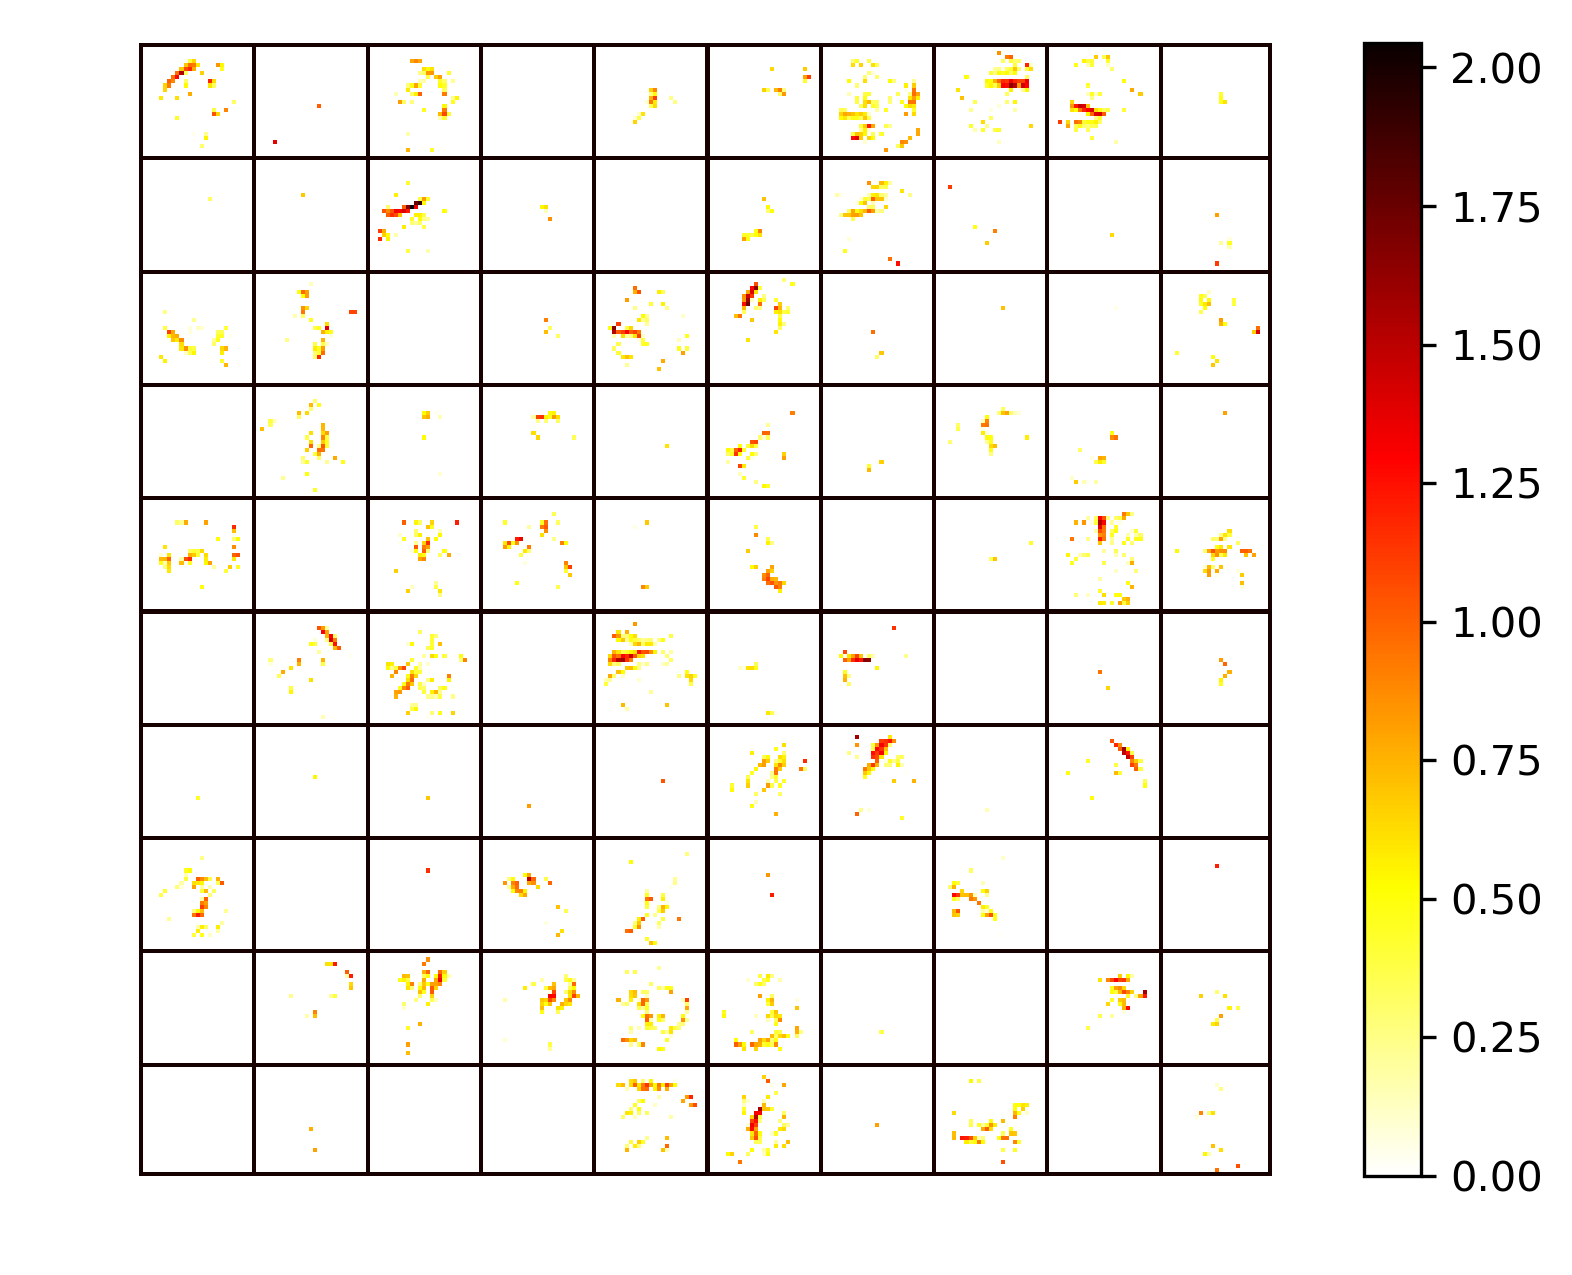

In [80]:
s = 0
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 5

z = np.zeros((28*10, 28*10))

for i in range(10):
    for j in range(10):
        s += 1
        z[i*28:(i+1)*28, j*28:(j+1)*28] =  np.abs((log_alpha * W)[s].reshape(28, 28))
        
z[::28] = 2
z[:, ::28] = 2
z[-1] = 2
z[:, -1] = 2
        
plt.imshow(z, cmap='hot_r')
plt.colorbar()
plt.axis('off')

In [78]:
z[::28]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Compression with Sparse Matrixes

In [60]:
import scipy
import numpy as np
from scipy.sparse import csc_matrix, csc_matrix, coo_matrix, dok_matrix

row, col, data = [], [], []
M = list(model.children())[0].W.data.numpy()
LA = list(model.children())[0].log_alpha.data.numpy()

for i in range(300):
    for j in range(28*28):
        if LA[i, j] < 3:
            row += [i]
            col += [j]
            data += [M[i, j]]

Mcsr = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcsc = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcoo = coo_matrix((data, (row, col)), shape=(300, 28*28))

In [61]:
np.savez_compressed('M_w', M)
scipy.sparse.save_npz('Mcsr_w', Mcsr)
scipy.sparse.save_npz('Mcsc_w', Mcsc)
scipy.sparse.save_npz('Mcoo_w', Mcoo)

In [62]:
ls -lah | grep _w

-rw-r--r--   1 ars  staff   856K Aug 24 18:50 M_w.npz
-rw-r--r--   1 ars  staff    30K Aug 24 18:50 Mcoo_w.npz
-rw-r--r--   1 ars  staff    30K Aug 24 18:50 Mcsc_w.npz
-rw-r--r--   1 ars  staff    30K Aug 24 18:50 Mcsr_w.npz
